In [173]:
import pandas as pd
import networkx as nx 
import glob
import numpy as np
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from matplotlib import pyplot as plt
import time
import os
from collections import Counter
%matplotlib inline


In [174]:
tweets = pd.read_csv('tweets.csv')

In [175]:
tweets = tweets[tweets['text'].apply(lambda x: str(x)[:2] == "RT")]

In [176]:
def get_user(text): 
    try:
        start = text.index('@')
        end = text.index(':')
        return text[start+1:end]
    except ValueError: 
        return float('nan')

In [177]:
tweets['original_poster'] = tweets['text'].apply(get_user)

In [178]:
tweets = tweets.rename({'user_key': 'retweeter'}, axis=1)

In [179]:
len(set(tweets['original_poster'])), len(set(tweets['retweeter']))

(36864, 334)

In [180]:
all_users = set(tweets['original_poster']).union(set(tweets['retweeter']))
all_users = dict(zip(all_users, range(len(all_users))))

In [181]:
tweets = tweets.reset_index(drop=True).dropna(subset='original_poster')

In [182]:
tweets['original_poster_id'] = tweets['original_poster'].apply(lambda x: all_users[x])
tweets['retweeter_id'] = tweets['retweeter'].apply(lambda x: all_users[x])

In [183]:
tweets_g = tweets.groupby(['retweeter_id', 'original_poster_id'])\
    .count()['retweeter'].reset_index()\
    .rename({'retweeter': 'retweets_count'}, axis=1)\
    .sort_values('retweets_count')

In [184]:
tweets_g['retweets_count'] = tweets_g['retweets_count'].apply(float)

In [185]:
tweets_g.to_csv('retweets.csv',index=False, sep=' ',header=False)

In [186]:
g = nx.read_weighted_edgelist('retweets.csv')

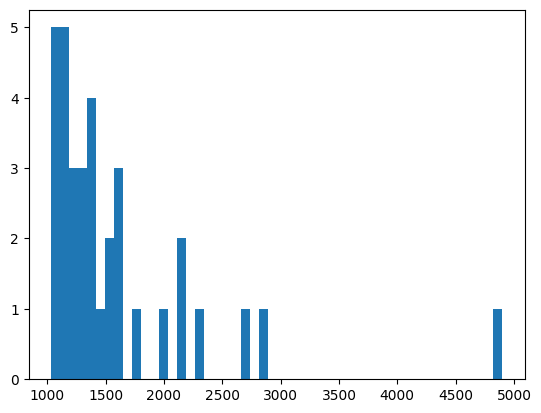

In [187]:
import helpers
degrees = np.array(list(dict(g.degree).values()))
plt.hist(degrees[degrees>1000], bins=50);

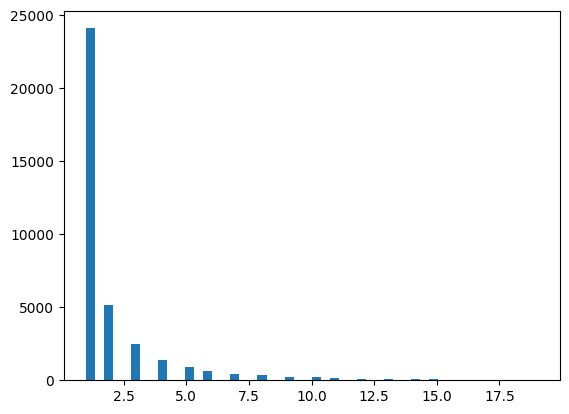

In [188]:
plt.hist(degrees[degrees<20], bins=50);

In [189]:
degrees_df = pd.DataFrame()
degrees_df['degree'] = degrees
degrees_df['node_id'] = np.array(list(dict(g.degree).keys()))
degrees_df['node_id'] = degrees_df['node_id'].apply(int)

In [190]:
degrees_df[degrees_df['degree'] > 1000].merge(tweets, left_on='node_id', right_on='original_poster_id')['original_poster'].drop_duplicates()

0            hyddrox
11        mr_clampin
19      queenofthewo
31      mrclydepratt
32     melanymelanin
33    traceyhappymom
37     brianaregland
Name: original_poster, dtype: object

In [191]:
nodes = degrees_df[(degrees_df['degree'] > 30) & (degrees_df['degree'] < 50)].head(5)['node_id'].to_list()

In [192]:
tweets_small = tweets_g[(tweets_g['original_poster_id'].isin(nodes)) | (tweets_g['retweeter_id'].isin(nodes))]
tweets_small.to_csv('retweets_small.csv',index=False, sep=' ',header=False)
g_small = nx.read_weighted_edgelist('retweets_small.csv')

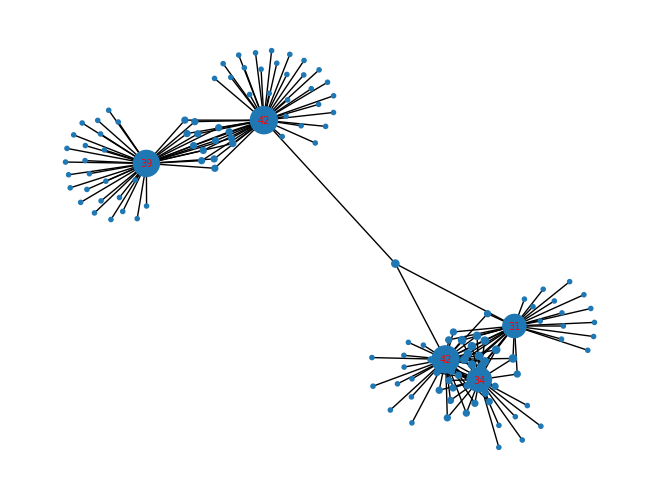

In [223]:
pos = nx.spring_layout(g_small)
edge_labels = nx.get_edge_attributes(g_small,'weight')
edge_labels = {tuple(keys[:2]): value for keys, value in edge_labels.items()}

nx.draw(g_small, node_size=np.array(list(dict(g_small.degree()).values()))*9, pos=pos)
nx.draw_networkx_labels(g,pos,{k:v if v > 5 else '' for k,v in dict(g_small.degree).items()},
                        font_size=7,font_color='r');